In [1]:
from matplotlib.ticker import FormatStrFormatter as fsf
import matplotlib.pyplot as plt
# from plots.mpltoolkit import mpl_loc, named_colors, markers, fancy_legend, negative_log, load_style_sheet
from plots.mpltoolkit import mpl_loc, named_colors, markers, fancy_legend, load_style_sheet
import numpy as np
import math as m
import vice
import sys
import os
sys.path.append("..")
from src.utils import mu, get_velocity_profile
load_style_sheet("papers")
print(sys.version_info)

/Users/astrobeard/Work/Research/VICErepos/VICE/vice/__init__.py:141: UserWarning: Using un-released version of VICE
  warnings.warn("Using un-released version of VICE", UserWarning)


sys.version_info(major=3, minor=10, micro=2, releaselevel='final', serial=0)


In [20]:
output = vice.output("../outputs/constant/vgas-0-zerometinfall-withoutflows")

/var/folders/1p/lm_h7y810f9_7ygnvr2tjc_w0000gn/T/ipykernel_26482/361178779.py:92: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


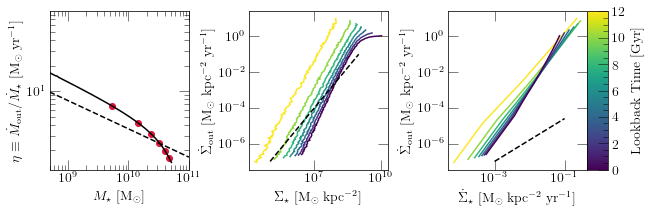

In [21]:
LOOKBACKS = [0.01, 2, 4, 6, 8, 10, 12][::-1]
COLORMAP = "viridis"

fig = plt.figure(figsize = (10, 3))
ax1 = fig.add_subplot(131)
ax2 = fig.add_subplot(132)
ax3 = fig.add_subplot(133)
ax1.set_xlabel(r"$M_\star$ [M$_\odot$]")
ax1.set_ylabel(r"$\eta \equiv \dot M_\text{out} / \dot{M}_\star$ [M$_\odot$ yr$^{-1}$]")
ax2.set_xlabel(r"$\Sigma_\star$ [M$_\odot$ kpc$^{-2}$]")
ax2.set_ylabel(r"$\dot{\Sigma}_\text{out}$ [M$_\odot$ kpc$^{-2}$ yr$^{-1}$]")
ax3.set_xlabel(r"$\dot \Sigma_\star$ [M$_\odot$ kpc$^{-2}$ yr$^{-1}$]")
ax3.set_ylabel(r"$\dot{\Sigma}_\text{out}$ [M$_\odot$ kpc$^{-2}$ yr$^{-1}$]")
ax1.set_xscale("log")
ax1.set_yscale("log")
ax2.set_xscale("log")
ax2.set_yscale("log")
ax3.set_xscale("log")
ax3.set_yscale("log")
ax1.set_xlim([5e8, 1e11])
ax1.set_xticks([1e9, 1e10, 1e11])
# ax1.set_ylim([1, 20])

norm = plt.Normalize(vmin = min(LOOKBACKS), vmax = max(LOOKBACKS))
cmap = plt.cm.ScalarMappable(cmap = COLORMAP, norm = norm)
cbar_ax = fig.add_axes([0.9, 0.1, 0.05, 0.6])
cbar = plt.colorbar(cmap, cax = cbar_ax, orientation = "vertical")
cbar.set_label("Lookback Time [Gyr]")
# cbar.ax.xaxis.set_ticks_position("top")
# cbar.ax.xaxis.set_label_position("top")
cbar.set_ticks([0, 2, 4, 6, 8, 10, 12])

def plot_outflow_evol(ax, output, zone_width = 0.1, **kwargs):
    mstar = []
    eta = []
    for i in range(len(output.zones["zone0"].history["time"])):
        sfr = 0
        ofr = 0
        mstar.append(0)
        for j in range(len(output.zones.keys())):
            zone = output.zones["zone%d" % (j)]
            mstar[-1] += zone.history["mstar"][i]
            sfr += zone.history["sfr"][i]
            ofr += zone.history["ofr"][i]
        if sfr:
            eta.append(ofr / sfr)
        else:
            eta.append(float("inf"))
    radii = [zone_width * (i + 0.5) for i in range(len(output.zones.keys()))]
    ax.plot(mstar, eta, **kwargs)
    ax.scatter(mstar[::200], eta[::200], c = named_colors()["crimson"])
    

def plot_snapshot(ax_star, ax_sfr, output, lookback, zone_width = 0.1, **kwargs):
    diff = [abs(_ - lookback) for _ in output.zones["zone0"].history["lookback"]]
    idx = diff.index(min(diff))
    sigma_star = []
    sigma_sfr = []
    sigma_ofr = []
#     for i in range(len(output.zones.keys())):
    for i in range(int(15.5 / zone_width)):
        area = np.pi * (((i + 1) * zone_width)**2 - (i * zone_width)**2)
        zone = output.zones["zone%d" % (i)]
        sigma_star.append(zone.history["mstar"][idx] / area)
        sigma_sfr.append(zone.history["sfr"][idx] / area)
        sigma_ofr.append(zone.history["ofr"][idx] / area)
    ax_star.plot(sigma_star, sigma_ofr, **kwargs)
    ax_sfr.plot(sigma_sfr, sigma_ofr, **kwargs)

xvals = np.linspace(ax1.get_xlim()[0], ax1.get_xlim()[1], 100)
yvals = [3.6 * (x / 1e10)**(-1/3) for x in xvals]
ax1.plot(xvals, yvals, c = named_colors()["black"], linestyle = "--")
plot_outflow_evol(ax1, output, c = named_colors()["black"])

for i in range(len(LOOKBACKS)):
    kwargs = {
        "c": cmap.to_rgba(LOOKBACKS[i])
    }
    plot_snapshot(ax2, ax3, output, LOOKBACKS[i], **kwargs)
    
kwargs = {
    "c": named_colors()["black"],
    "linestyle": "--"
}
xvals = np.logspace(5, 9, 100)
yvals = [1.e-7 * (x / 1e5)**1.5 for x in xvals]
ax2.plot(xvals, yvals, **kwargs)
xvals = np.logspace(-3, -1, 100)
yvals = [1.e-7 * (x / 1e-3)**1.2 for x in xvals]
ax3.plot(xvals, yvals, **kwargs)

plt.tight_layout()
plt.subplots_adjust(right = 0.82)
cbar_ax.set_position([
    ax3.get_position().x1,
    ax3.get_position().y0,
    0.03,
    ax3.get_position().y1 - ax3.get_position().y0
])
plt.show()